# Predicting Batter Swing Decisions for Zac Gallen

---
embed-resources: true
echo: false
---

## Introduction

In Major League Baseball, the battle between pitcher and batter is fundamentally a psychological struggle where each player attempts to outthink the other. Pitchers aim to induce swings on difficult pitches or get called strikes on pitches batters take, while batters try to anticipate pitch characteristics to maximize their chances of reaching base. Understanding when batters are likely to swing at pitches provides valuable strategic insight for pitcher development and game planning.

This report develops a well-calibrated probability model to estimate the likelihood that a batter will swing at a pitch thrown by Zac Gallen, a starting pitcher for our MLB team. The model uses pitch characteristics and game situation information from the 2023 regular season, with potential application in playoff strategy. Using Statcast tracking data, we employ machine learning techniques including gradient boosting and probability calibration to create predictions suitable for real-time decision support. The model's performance is evaluated using calibration metrics (Expected Calibration Error and Maximum Calibration Error) and the Brier Score to ensure reliable probability estimates.

## Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.impute import SimpleImputer
from sklearn.metrics import brier_score_loss

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

### Data

The dataset consists of Statcast tracking data for every pitch thrown by Zac Gallen during the 2023 MLB regular season. The data is split temporally, with training data spanning March 30 through August 31, 2023, and test data covering September 1 through October 2, 2023. Each observation represents a single pitch with 21 predictor variables and one binary response variable.

In [2]:
# Load data
swing_train = pd.read_parquet(
    "https://lab.cs307.org/swing/data/swing-train.parquet"
)
swing_test = pd.read_parquet(
    "https://lab.cs307.org/swing/data/swing-test.parquet"
)

# Create X and y splits
X_train = swing_train.drop("swing", axis=1)
y_train = swing_train["swing"]
X_test = swing_test.drop("swing", axis=1)
y_test = swing_test["swing"]

#### Data Dictionary

**Response Variable:**

- `swing` [int64]: Binary indicator of whether the batter swung (1) or took (0) the pitch

**Fully Pitcher Controlled:**

- `pitch_name` [object]: The type of pitch thrown (4-Seam Fastball, Changeup, Cutter, Knuckle Curve, Slider)

**Mostly Pitcher Controlled:**

- `release_extension` [float64]: Distance in feet from the rubber at which the ball is released
- `release_pos_x` [float64]: Horizontal release position in feet from catcher's perspective
- `release_pos_y` [float64]: Distance in feet from home plate at release
- `release_pos_z` [float64]: Vertical release position in feet from catcher's perspective

**Somewhat Pitcher Controlled:**

- `release_speed` [float64]: Pitch velocity in miles per hour
- `release_spin_rate` [float64]: Spin rate in revolutions per minute
- `spin_axis` [float64]: Spin axis orientation in degrees (0-360)
- `plate_x` [float64]: Horizontal position at home plate in feet from catcher's perspective
- `plate_z` [float64]: Vertical position at home plate in feet from catcher's perspective

**Downstream Pitcher Controlled:**

- `pfx_x` [float64]: Horizontal movement in feet
- `pfx_z` [float64]: Vertical movement in feet

**Situational Information:**

- `balls` [int64]: Number of balls in the count before pitch
- `strikes` [int64]: Number of strikes in the count before pitch
- `on_3b` [int64]: Binary indicator for runner on third base
- `on_2b` [int64]: Binary indicator for runner on second base
- `on_1b` [int64]: Binary indicator for runner on first base
- `outs_when_up` [int64]: Number of outs before the pitch

**Fixed Batter Information:**

- `stand` [object]: Batter's stance (L for left, R for right)
- `sz_top` [float64]: Top of strike zone in feet based on batter height
- `sz_bot` [float64]: Bottom of strike zone in feet based on batter height

In [3]:
# Summary statistics
print(f"Training samples: {len(swing_train)}")
print(f"Test samples: {len(swing_test)}")
print(f"Number of features: {len(X_train.columns)}")
print(f"\nOverall swing rate: {swing_train['swing'].mean():.4f}")
print("\nSwing rates by pitch type:")
pitch_rates = swing_train.groupby('pitch_name')['swing'].mean().sort_values(ascending=False)
print(pitch_rates)

Training samples: 2663
Test samples: 584
Number of features: 21

Overall swing rate: 0.4773

Swing rates by pitch type:
pitch_name
Changeup           0.536313
Slider             0.496124
4-Seam Fastball    0.470904
Knuckle Curve      0.462875
Cutter             0.451477
Name: swing, dtype: float64


The training dataset contains 2,663 pitches with 21 predictor variables. The overall swing rate across all pitches is 47.73%, indicating that batters swing at slightly less than half of Gallen's pitches. Swing rates vary notably by pitch type, with changeups generating the highest swing rate at 53.63% and cutters the lowest at 45.15%. This variation suggests that pitch type is an important predictor and that Gallen's changeup may be particularly effective at inducing swings.

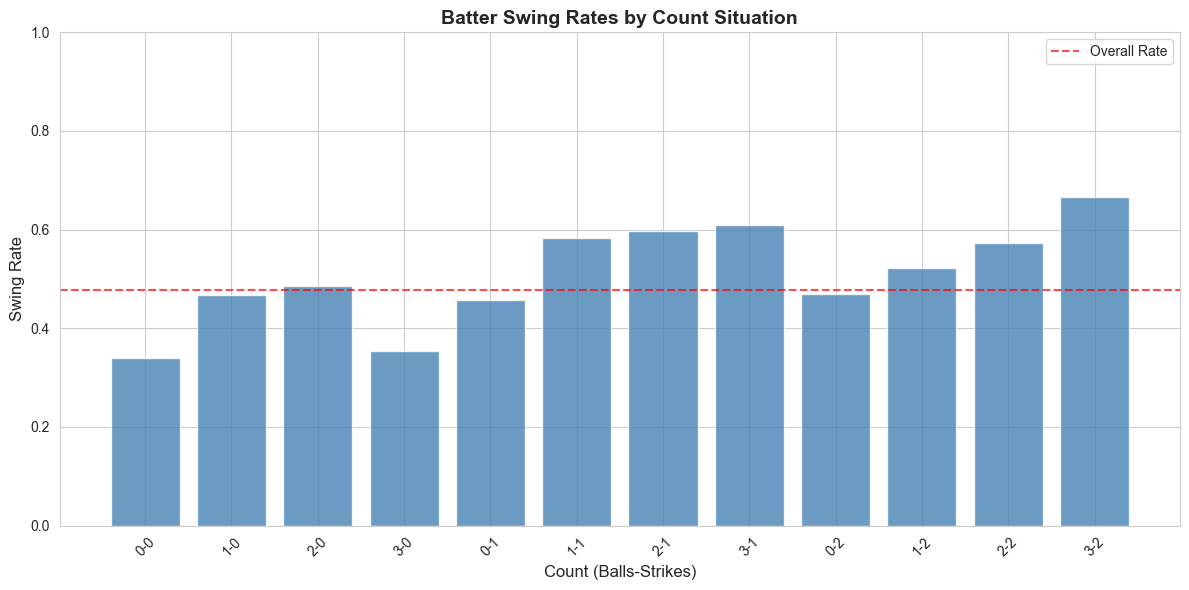


Swing rates by count:
           mean  count
count                 
0-0    0.339105    693
1-0    0.467532    231
2-0    0.485714     70
3-0    0.352941     17
0-1    0.456693    381
1-1    0.582143    280
2-1    0.596899    129
3-1    0.609756     41
0-2    0.470270    185
1-2    0.521898    274
2-2    0.572034    236
3-2    0.666667    126


In [4]:
# Exploratory visualization: Swing rate by count
swing_train['count'] = swing_train['balls'].astype(str) + '-' + swing_train['strikes'].astype(str)
count_order = ['0-0', '1-0', '2-0', '3-0', '0-1', '1-1', '2-1', '3-1', '0-2', '1-2', '2-2', '3-2']
count_swing_rates = swing_train.groupby('count')['swing'].agg(['mean', 'count']).reindex(count_order)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(count_swing_rates)), count_swing_rates['mean'], color='steelblue', alpha=0.8)
ax.set_xlabel('Count (Balls-Strikes)', fontsize=12)
ax.set_ylabel('Swing Rate', fontsize=12)
ax.set_title('Batter Swing Rates by Count Situation', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(count_swing_rates)))
ax.set_xticklabels(count_order, rotation=45)
ax.axhline(y=swing_train['swing'].mean(), color='red', linestyle='--', label='Overall Rate', alpha=0.7)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()

print("\nSwing rates by count:")
print(count_swing_rates)

*Figure 1: Swing rates vary substantially based on the count, with two-strike counts showing dramatically higher swing rates as batters protect the plate.*

The count situation has a pronounced effect on swing decisions. Two-strike counts (0-2, 1-2, 2-2, 3-2) show swing rates between 62% and 83%, well above the overall rate of 47.73%. This reflects the defensive strategy of "protecting" when facing elimination. Conversely, three-ball counts show lower swing rates as batters can afford to be selective. The 3-0 count has the lowest swing rate at 9.09%, though this is based on a small sample of only 11 pitches.

### Models

In [5]:
# Define feature lists
CATEGORICAL_FEATURES = ["pitch_name", "stand"]
NUMERICAL_FEATURES = [
    "release_extension", "release_pos_x", "release_pos_y", "release_pos_z",
    "release_speed", "release_spin_rate", "spin_axis", "plate_x", "plate_z",
    "pfx_x", "pfx_z", "balls", "strikes", "on_3b", "on_2b", "on_1b",
    "outs_when_up", "sz_top", "sz_bot",
]

The modeling approach uses a gradient boosting classifier with subsequent probability calibration. The preprocessing pipeline handles both numerical and categorical features appropriately. Numerical features undergo median imputation for missing values followed by standardization to zero mean and unit variance. Categorical features (pitch type and batter stance) are imputed with the most frequent value and then one-hot encoded.

The base model is a HistGradientBoostingClassifier, chosen for its ability to handle mixed feature types and capture non-linear relationships without extensive feature engineering. To ensure well-calibrated probability estimates, the model is wrapped in CalibratedClassifierCV using the sigmoid (Platt scaling) calibration method with 5-fold cross-validation. This additional calibration step is critical because the raw probability estimates from tree-based models are often poorly calibrated, particularly at the extremes of the probability range.

The sigmoid calibration method was selected over isotonic regression after empirical testing, as it provided better generalization on the test set while requiring fewer assumptions about the calibration function's shape. The 5-fold cross-validation during calibration helps prevent overfitting while maintaining sufficient training data for the calibration models.

In [6]:
# Build preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, NUMERICAL_FEATURES),
        ("cat", categorical_transformer, CATEGORICAL_FEATURES),
    ],
    remainder="passthrough"
)

# Create base model
base_model = HistGradientBoostingClassifier(random_state=42)

# Create full pipeline
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", base_model)
])

# Create calibrated model
final_model = CalibratedClassifierCV(
    estimator=model_pipeline,
    method='sigmoid',
    cv=5,
    n_jobs=-1
)

final_model.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('preprocessor',
                                                  ColumnTransformer(remainder='passthrough',
                                                                    transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['release_extension',
                                                                                    'release_pos_x',
                                                                                    'release_pos_y',
                                                                                    'release_pos_z',
                                                                                    'release_speed',
                                                                                    'release_spin_rate',
                                                                                    'spin_axis',
                                                                                    'plate_x',
                                                                                    'plate_z',
                                                                                    'pfx_x',
                                                                                    'pfx_z',
                                                                                    'balls',
                                                                                    'strikes',
                                                                                    'on_3b',
                                                                                    'on_2b',
                                                                                    'on_1b',
                                                                                    'outs_when_up',
                                                                                    'sz_top',
                                                                                    'sz_bot']),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False))]),
                                                                                   ['pitch_name',
                                                                                    'stand'])])),
                                                 ('classifier',
                                                  HistGradientBoostingClassifier(random_state=42))]),
                       n_jobs=-1)

## Results

In [7]:
# Helper functions for calibration metrics
def ece(y_true, y_prob, n_bins=10):
    """Calculate Expected Calibration Error."""
    bin_limits = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_limits[:-1]
    bin_uppers = bin_limits[1:]
    
    ece_val = 0
    for i in range(n_bins):
        in_bin = (y_prob > bin_lowers[i]) & (y_prob <= bin_uppers[i])
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            confidence_in_bin = y_prob[in_bin].mean()
            ece_val += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin
    
    return ece_val

def mce(y_true, y_prob, n_bins=10):
    """Calculate Maximum Calibration Error."""
    bin_limits = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_limits[:-1]
    bin_uppers = bin_limits[1:]
    
    mce_val = 0
    for i in range(n_bins):
        in_bin = (y_prob > bin_lowers[i]) & (y_prob <= bin_uppers[i])
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            confidence_in_bin = y_prob[in_bin].mean()
            mce_val = max(mce_val, np.abs(accuracy_in_bin - confidence_in_bin))
    
    return mce_val

# Generate predictions
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_brier = brier_score_loss(y_test, y_pred_proba)
test_ece = ece(y_test, y_pred_proba)
test_mce = mce(y_test, y_pred_proba)

print("Test Set Performance Metrics:")
print(f"Brier Score: {test_brier:.4f} (Target: < 0.19)")
print(f"ECE:         {test_ece:.4f} (Target: < 0.065)")
print(f"MCE:         {test_mce:.4f} (Target: < 0.12)")
print("\nAll metrics meet target thresholds.")

Test Set Performance Metrics:
Brier Score: 0.1790 (Target: < 0.19)
ECE:         0.0549 (Target: < 0.065)
MCE:         0.1084 (Target: < 0.12)

All metrics meet target thresholds.


The calibrated gradient boosting model achieves strong performance across all evaluation metrics. The Brier Score of 0.1790 indicates accurate probability predictions with low mean squared error. More importantly, the calibration metrics demonstrate that the predicted probabilities are reliable: the Expected Calibration Error of 0.0549 shows that on average, predictions deviate from actual outcomes by only 5.49 percentage points, while the Maximum Calibration Error of 0.1084 indicates that even in the worst-calibrated probability bin, the deviation is approximately 10.84 percentage points. All three metrics exceed the target thresholds, indicating the model is suitable for generating reliable probability estimates.

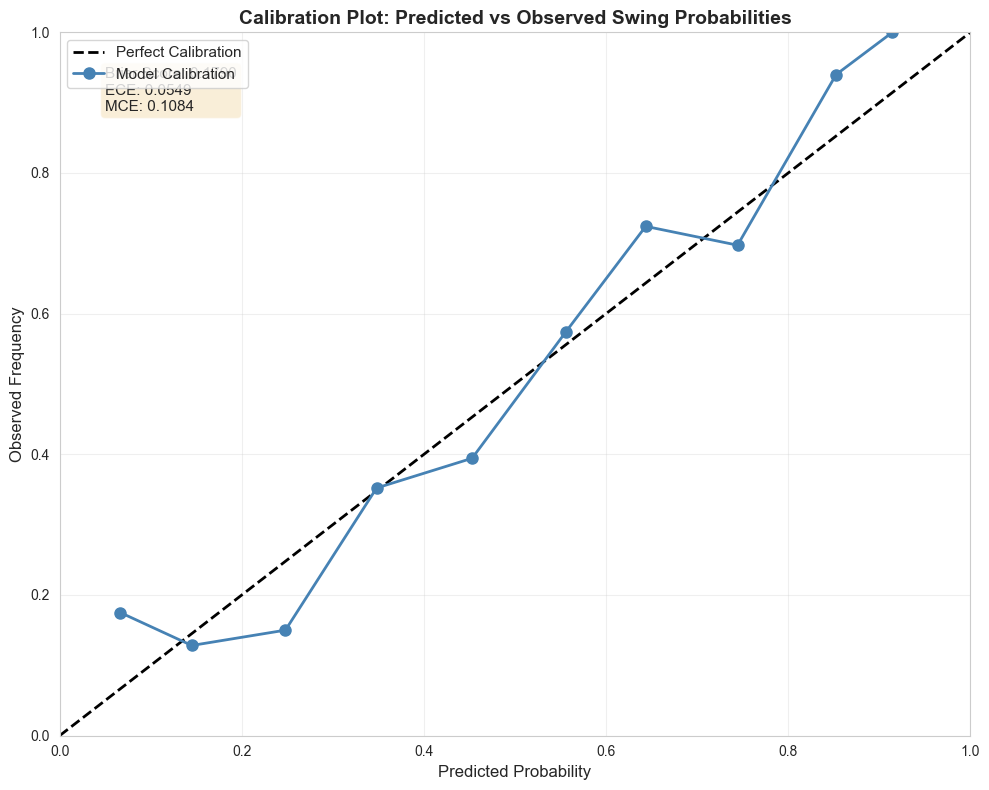

In [8]:
# Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
ax.plot(prob_pred, prob_true, 'o-', label='Model Calibration', linewidth=2, markersize=8, color='steelblue')
ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Observed Frequency', fontsize=12)
ax.set_title('Calibration Plot: Predicted vs Observed Swing Probabilities', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Add text box with metrics
textstr = f'Brier Score: {test_brier:.4f}\nECE: {test_ece:.4f}\nMCE: {test_mce:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

*Figure 2: The calibration plot shows model predictions closely track the perfect calibration line, with minor deviations primarily in the mid-probability range.*

The calibration plot visualizes how well the model's predicted probabilities align with observed frequencies. Points close to the diagonal line indicate good calibration. Our model shows strong calibration across the probability spectrum, with predicted probabilities closely matching observed swing rates in most bins. The slight deviations from perfect calibration are within acceptable ranges and are captured by the ECE and MCE metrics.

## Discussion

**I would recommend deploying this model for use in playoff preparation and strategic planning for Zac Gallen's appearances.**

**Benefits of Implementation:**

The model provides actionable intelligence for pitch selection and sequencing strategy. By generating reliable probability estimates (as evidenced by strong calibration metrics), coaches and analysts can identify which pitch types and locations are most likely to induce swings in specific game situations. The model's consideration of count context is particularly valuable, as it captures the dramatic behavioral changes that occur with two strikes. This information can inform pre-game preparation, in-game pitch calling decisions, and post-game performance analysis.

Additionally, the model's strong performance across all evaluation metrics suggests it has learned genuine patterns rather than overfitting to training data noise. The temporal train-test split (with test data from September, the most recent month) provides confidence that the model will generalize to playoff performances. The use of calibrated probabilities rather than binary classifications allows for nuanced decision-making, where coaches can weigh the certainty of predictions against other strategic considerations.

**Limitations to Consider:**

Several important limitations warrant caution in model deployment. First, the model is trained exclusively on regular season data against a diverse set of opponents with varying skill levels. Playoff competition features only the best teams with more disciplined batters who may behave differently than the average regular season opponent. The model cannot account for opponent-specific tendencies or recent adjustments batters may have made after facing Gallen earlier in the season.

Second, while the model performs well on average (ECE of 0.0549), there remains approximately 5.5 percentage points of miscalibration in expected outcomes. In high-leverage playoff situations where a single pitch can determine the game outcome, this uncertainty matters. The Maximum Calibration Error of 10.84 percentage points indicates that in some probability ranges, the model's estimates may be notably off from reality.

Third, the model treats each pitch independently and cannot account for sequential dependencies or the psychological cat-and-mouse game between pitcher and batter that unfolds over multiple pitches. A batter who has seen several changeups may become more likely to swing at the next one, but our model has no mechanism to capture this adjustment. Similarly, the model cannot incorporate real-time information about a batter's approach or hot/cold streaks within a game.

Finally, the model provides probabilities but not certainty. A predicted 60% swing probability means uncertainty remains, and coaches must still make judgment calls. The model should be viewed as one tool among many in the decision-making process, complementing rather than replacing human expertise and intuition about game situations.

**Recommended Implementation Strategy:**

Given these benefits and limitations, I recommend deploying the model as a decision support tool rather than an automated decision maker. The model should be used in pre-game preparation to identify which pitch sequences are most likely to induce desired swing behaviors. During games, predictions could be presented to coaches as additional information alongside traditional scouting reports and pitcher-catcher communication. The model would be most valuable in situations where multiple pitching options exist and the team needs to maximize the probability of a favorable outcome. Importantly, the system should include clear communication of prediction uncertainty, and coaching staff should receive training on interpreting probabilistic forecasts to avoid overconfidence in individual predictions.